**Ejercicio Latam**: Data Scientist Challenge - LATAM Airlines.

**Por**: *David Doncel Ballén*, creado en agosto 10 de 2022.

**Code Repository**: https://github.com/DaDo82/Machine-Learning

# Probabilidad de atraso de los vuelos

- Fecha-I : Fecha y hora programada del vuelo.
- Vlo-I : Número de vuelo programado.
- Ori-I : Código de ciudad de origen programado.
- Des-I : Código de ciudad de destino programado.
- Emp-I : Código aerolínea de vuelo programado.
- Fecha-O : Fecha y hora de operación del vuelo.
- Vlo-O : Número de vuelo de operación del vuelo.
- Ori-O : Código de ciudad de origen de operación
- Des-O : Código de ciudad de destino de operación.
- Emp-O : Código aerolínea de vuelo operado.
- DIA : Día del mes de operación del vuelo.
- MES : Número de mes de operación del vuelo.
- AÑO : Año de operación del vuelo.
- DIANOM : Día de la semana de operación del vuelo.
- TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional.
- OPERA : Nombre de aerolínea que opera.
- SIGLAORI : Nombre ciudad origen.
- SIGLADES : Nombre ciudad destino.

## Análisis exploratorio de datos

In [1]:
# Principales librias que se usaran durante la ejecución del script

from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import datetime
from datetime import datetime
from datetime import datetime, date, timedelta

import seaborn; seaborn.set()
import matplotlib.pylab as plt

In [2]:
try:
    import common
    DATASET = common.dataDirectory()
except ImportError:
    DATASET = Path().resolve() / 'dataset'

In [3]:
# Cargue de datos a Datasets

SCL_CSV = DATASET / 'dataset_SCL.csv'
METEORO = DATASET / 'meteoro.csv'

In [4]:
# Lectura de los datos

scl = pd.read_csv(SCL_CSV, low_memory=False)

In [5]:
#Exploración de los datos

scl.dropna().describe(include='all', datetime_is_numeric=True)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
count,68205,68205,68205,68205,68205,68205,68205,68205,68205,68205,68205.000000,68205.000000,68205.000000,68205,68205,68205,68205,68205
unique,53252,584,1,64,30,62774,861,1,63,32,NaN,NaN,NaN,7,2,23,1,62
top,2017-07-28 13:30:00,174,SCEL,SCFA,LAN,2017-05-19 07:01:00,174,SCEL,SCFA,LAN,NaN,NaN,NaN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires
freq,6,686,68205,5787,37611,5,649,68205,5786,20988,NaN,NaN,NaN,10292,36966,40892,68205,6335
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.714742,6.622667,2017.000029,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.782941,3.523281,0.005415,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,2017.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3.000000,2017.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,7.000000,2017.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,10.000000,2017.000000,NaN,NaN,NaN,NaN,NaN


## 1. ¿Cómo se distribuyen los datos?

La fila "unique" nos indica el número de valores diferentes que hay. Por ejemplo, tenemos 23 valores diferentes para la columna OPERA, es decir 23 aerolineas operan en el aeropuerto de Santigo de Chile.

### ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

No hay datos númericos para incluir en el diseño de modelo y su explicación, todas las varibales son categoricas, por lo cual, llama la atención que son datos que requierien ser transformados para diseñar el respectivo modelo.
Tambien se aprecia que no hay datos faltantes, lo cual garantiza el uso total de los datos.

Por otra parte, se aprecia que las variables corresponden a labores técnicas de la operación, por esto, me interesa poder complementar los datos con variables meteorológicas y examinar si este factor tiene incidencia en la predicción del modelo.

## 2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv

In [6]:
#Cálculo de la primera variable "temporada_alta"

conditionlist = [
    (scl['Fecha-I'] >= '2017-12-15'),
    (scl['Fecha-I'] <= '2017-03-03'),
    (scl['Fecha-I'] >= '2017-07-15') & (scl['Fecha-I'] <'2017-07-31'),
    (scl['Fecha-I'] >= '2017-09-11') & (scl['Fecha-I'] <'2017-09-30')]
choicelist = [1, 1,  1, 1]
scl['temporada_alta'] = np.select(conditionlist, choicelist, default= 0)

In [7]:
# Cálculo de la segunda variable "dif_min"

scl['Fecha-O']= pd.to_datetime(scl['Fecha-O'], format='%Y-%m-%d %H:%M:%S')
#scl['Fecha-I']=scl.Fecha-I.map(lambda x : datatime.strptime(x, '%d/%m/%Y %H:%M:%S'))
scl['Fecha-I']= pd.to_datetime(scl['Fecha-I'], format='%Y-%m-%d %H:%M:%S')
# reindexar el dataframe
scl.index = scl['Fecha-I']

scl['dif_min'] = scl['Fecha-O'] - scl['Fecha-I']
scl['dif_min']=abs(scl['dif_min'] / timedelta(minutes=1))
print(scl['dif_min'].head(5))

Fecha-I
2017-01-01 23:30:00    3.0
2017-01-02 23:30:00    9.0
2017-01-03 23:30:00    9.0
2017-01-04 23:30:00    3.0
2017-01-05 23:30:00    2.0
Name: dif_min, dtype: float64


In [8]:
#Cálculo de la tercera variable "atraso_15"

conditionlist = [
    (scl['dif_min'] > 15)]
choicelist = [1]
scl['atraso_15'] = np.select(conditionlist, choicelist, default= 0)

In [9]:
#Cálculo de la cuarta variable "periodo_dia"

scl['Fecha_seg']=(scl['Fecha-I'].dt.strftime('%H%M%S')).astype(int)/100

conditionlist = [
    (scl['Fecha_seg'] >= 500) & (scl['Fecha_seg'] <= 1159),
    (scl['Fecha_seg'] >= 1200) & (scl['Fecha_seg'] <= 1859),
    (scl['Fecha_seg'] >= 1900),
    (scl['Fecha_seg'] <= 459)]
choicelist = ['mañana', 'tarde', 'noche', 'noche']

scl['periodo_dia'] = np.select(conditionlist, choicelist, default= 'Not Specified')


In [10]:
#Cálculo de la cuarta variable "periodo_dia"
scl['Fecha_seg']=(scl['Fecha-I'].dt.strftime('%H%M%S')).astype(int)/100

conditionlist = [
    (scl['Fecha_seg'] >= 500) & (scl['Fecha_seg'] <= 1159),
    (scl['Fecha_seg'] >= 1200) & (scl['Fecha_seg'] <= 1859),
    (scl['Fecha_seg'] >= 1900),
    (scl['Fecha_seg'] <= 459)]
choicelist = ['1', '2', '3', '3']

scl['periodo_dia2'] = np.select(conditionlist, choicelist, default= 'Not Specified')

In [11]:
# Exportando a un archivo csv las variables creadas

scl[['temporada_alta', 'dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv', encoding = 'utf-8')

## 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?

Las siguientes gráficas muestran el comportamiento del atraso en minutos en diferentes temporalidades (año, semana, dia y horas). Esto permite identificar cambios en las tasas para ciertos puntos o momentos.

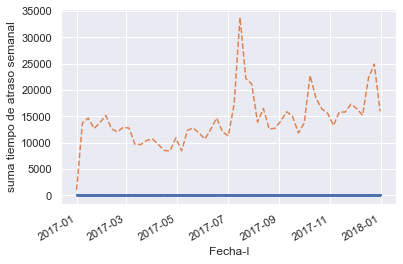

In [12]:
# Análisis visual del comportamiento de atraso semanal

scl['dif_min'].plot()
weekly = scl['dif_min'].resample('W').sum()
weekly.plot(style=['--',])
plt.ylabel('suma tiempo de atraso semanal');

Fecha-I
2017-01-01 23:30:00         NaN
2017-01-02 23:30:00    3.000000
2017-01-03 23:30:00    3.000000
2017-01-04 23:30:00    1.000000
2017-01-05 23:30:00    0.666667
Name: rend_diario, dtype: float64

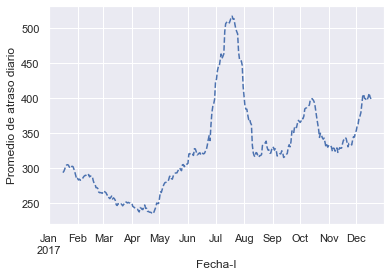

In [13]:
# Análisis visual del comportamiento de atraso diario

daily = scl['dif_min'].resample('D').mean()
daily.rolling(30, center=True).sum().plot(style=['--'])
plt.ylabel('Promedio de atraso diario');

# calculando rendimiento acumulado diario para identificar los cambios significativos, como sucede en los días de Julio.
rendimiento_diario = (1 + scl['dif_min'].pct_change()).cumprod()
scl['rend_diario'] = rendimiento_diario
scl['rend_diario'][:5]

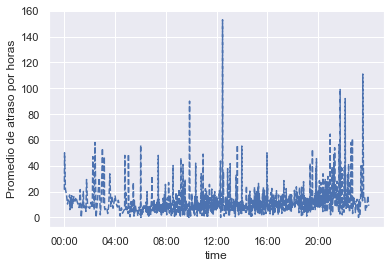

In [14]:
# Análisis visual del comportamiento de atraso en horas del día.

by_time = scl['dif_min'].groupby(scl['dif_min'].index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['--'])
plt.ylabel('Promedio de atraso por horas');

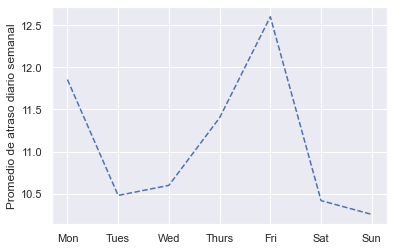

In [15]:
# Análisis visual del comportamiento de atraso diario semanal

by_weekday = scl['dif_min'].groupby(scl['dif_min'].index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['--'])
plt.ylabel('Promedio de atraso diario semanal');

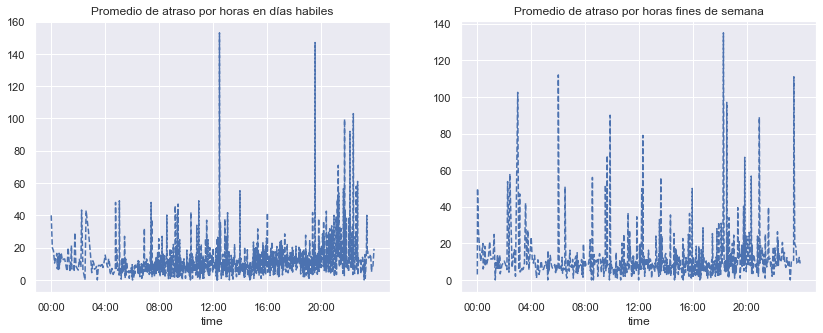

In [16]:
# Análisis visual del comportamiento de atraso en días habiles y fines de semana

weekend = np.where(scl['dif_min'].index.weekday < 5, 'Weekday', 'Weekend')
by_time = scl['dif_min'].groupby([weekend, scl['dif_min'].index.time]).mean()


import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time['Weekday'].plot(ax=ax[0], title='Promedio de atraso por horas en días habiles',
                           xticks=hourly_ticks, style=['--']);
by_time['Weekend'].plot(ax=ax[1], title='Promedio de atraso por horas fines de semana',
                           xticks=hourly_ticks, style=[ '--']);

Por lo tanto, las variables que incluyen la temporalidad categorizada son candidatas a incluir en el modelo.

### ¿Qué variables esperarías que más influyeran en predecir atrasos?

Del set de datos proporcionados las variables que pueden influir son:
- fecha (día y época del año)
- hora del vuelo
- Aerolinea.

Y en cuanto a los datos gestionados: la precipitación, la velocidad y dirección del viento, la nubosidad que puede inferirse por cantidad irradiancia y la temperatura.

## 4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.

### Adicionando varibles meteorológicas de la NASA

- Fuente: https://power.larc.nasa.gov/data-access-viewer/  **
- Postal code: 9020000
- Postal address: Aeropuerto Internacional Comodoro Arturo Merino Benítez, 
- Capitán Manuel Ávalos Prado, 
- Pudahuel, 
- Provincia de Santiago, 
- Región Metropolitana de Santiago, 
- 9020000, 
- Chile

** En esta página web se tuvo acceso a los datos de meteorología.

#### Variables meteorologicas, fuente: NASA Prediction of Worldwide Energy Resource (POWER), disponible en web https://power.larc.nasa.gov/data-access-viewer/, consultado el día 10/08/2022

- PRECTOTCORR           MERRA-2 Precipitation Corrected (mm/day) 
- T2M                   MERRA-2 Temperature at 2 Meters (C) 
- ALLSKY_SFC_SW_DWN     CERES SYN1deg All Sky Surface Shortwave Downward Irradiance (kW-hr/m^2/day) 
- CLRSKY_SFC_SW_DWN     CERES SYN1deg Clear Sky Surface Shortwave Downward Irradiance (kW-hr/m^2/day) 
- WS2M                  MERRA-2 Wind Speed at 2 Meters (m/s) 
- WS50M                 MERRA-2 Wind Speed at 50 Meters (m/s) 
- WD50M                 MERRA-2 Wind Direction at 50 Meters (Degrees) 


In [17]:
# Creación del daset con datos meteorológicos

mtr = pd.read_csv(METEORO, low_memory=False)
print(mtr.head(5))

       DATE  YEAR  MO  DY  PRECTOTCORR    T2M  ALLSKY_SFC_SW_DWN  \
0  2017-1-1  2017   1   1          0.0  22.72               9.57   
1  2017-1-2  2017   1   2          0.0  23.04               9.67   
2  2017-1-3  2017   1   3          0.0  21.57               8.20   
3  2017-1-4  2017   1   4          0.0  21.87               9.73   
4  2017-1-5  2017   1   5          0.0  23.25               9.65   

   CLRSKY_SFC_SW_DWN  WS2M  WS50M   WD50M  
0               9.83  2.05   3.02  183.62  
1               9.91  2.06   3.14  181.06  
2               9.90  2.12   3.37  184.06  
3               9.98  2.02   3.17  179.19  
4               9.84  2.19   3.30  182.31  


In [18]:
# Generación del campo que servira de llave para la unión con los datos de los vuelos

scl['Fecha_J']=scl['AÑO'].apply(str)+ "-" +scl['MES'].apply(str)+ "-" +scl['DIA'].apply(str)

In [19]:
# Se crea un nuevo Dataset resultado del join

result = pd.merge(left = scl, right = mtr, how='left', left_on='Fecha_J',right_on="DATE")

In [20]:
# Análisis exploratorio de datos

result.describe(include='all', datetime_is_numeric=True)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,YEAR,MO,DY,PRECTOTCORR,T2M,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,WS2M,WS50M,WD50M
count,68206,68206,68206,68206,68206,68206,68205,68206,68206,68206,...,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
unique,NaN,584,1,64,30,NaN,861,1,63,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,174,SCEL,SCFA,LAN,NaN,174,SCEL,SCFA,LAN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,686,68206,5787,37611,NaN,649,68206,5786,20988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2017-07-05 12:11:25.320059648,NaN,NaN,NaN,NaN,2017-07-05 12:20:31.971380992,NaN,NaN,NaN,NaN,...,2017.000029,6.622585,15.714790,0.787819,15.289123,5.525773,6.805302,1.767093,3.127424,158.257250
min,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,2017-01-01 00:04:00,NaN,NaN,NaN,NaN,...,2017.000000,1.000000,1.000000,0.000000,-0.360000,0.690000,3.200000,0.830000,1.600000,40.000000
25%,2017-03-31 12:41:15,NaN,NaN,NaN,NaN,2017-03-31 12:51:15,NaN,NaN,NaN,NaN,...,2017.000000,3.000000,8.000000,0.000000,10.340000,3.060000,4.490000,1.430000,2.770000,139.380000
50%,2017-07-10 05:30:00,NaN,NaN,NaN,NaN,2017-07-10 05:37:00,NaN,NaN,NaN,NaN,...,2017.000000,7.000000,16.000000,0.000000,15.790000,5.410000,6.910000,1.770000,3.120000,167.380000
75%,2017-10-08 11:18:45,NaN,NaN,NaN,NaN,2017-10-08 11:19:45,NaN,NaN,NaN,NaN,...,2017.000000,10.000000,23.000000,0.140000,20.660000,8.030000,8.970000,2.060000,3.370000,180.190000
max,2017-12-31 23:55:00,NaN,NaN,NaN,NaN,2018-01-01 00:12:00,NaN,NaN,NaN,NaN,...,2018.000000,12.000000,31.000000,32.220000,27.300000,9.940000,10.160000,3.500000,7.350000,260.060000


In [21]:
#Preparando los datos para el entrenamiento se elmina 'dif_min' para evitar colinealidad

df_atraso= result[['atraso_15','temporada_alta','periodo_dia2','PRECTOTCORR','T2M','CLRSKY_SFC_SW_DWN', 'WS50M', 'WD50M']]

### Entrenamiento del modelo

In [22]:
# Generación del set de datos de las varibales explicativas y la variable respuesta

X = df_atraso.iloc[:, [1, 2,3,4,5,6,7]].values
y = df_atraso.iloc[:, 0].values

In [23]:
# Obtención de las muestra de entrenamieto y validación

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [24]:
# Estandarización de los datos tomando como parámetros la media y desviación estandar

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Performance y evaluación del modelo

In [25]:
# Ajuste de un modelo Random Forest

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [26]:
# Cálculo de la predicción del modelo

y_pred = classifier.predict(X_test)

In [27]:
# Precisión del modelo 
# ==============================================================================
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = y_pred,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 81.65868439057765%


In [28]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_pred)
cm1

array([[16523,   127],
       [ 3626,   186]], dtype=int64)

In [29]:
# Ajuste de un modelo Bernoulli Nayive Bayes 

from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(X_train, y_train)



BernoulliNB()

In [30]:
# Resultados predicción del modelo Bernoulli Nayive Bayes
y_pred2 = classifier.predict(X_test)
y_pred[-8:].round(2)

array([0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
# Precisión del modelo Bernoulli Nayive Bayes 
# ==============================================================================
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = y_pred2,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 81.65868439057765%


In [32]:
# Matriz de Confusion Bernoulli Nayive Bayes
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test, y_pred2)
cm2

array([[16523,   127],
       [ 3626,   186]], dtype=int64)

In [33]:
# Parámetros del modelo Bernoulli Nayive Bayes

yprob = model.predict_proba(X_test)
X_test[-8:].round(2)


array([[-0.69,  0.15, -0.25, -0.86, -1.38, -0.01, -1.42],
       [-0.69, -1.13, -0.29,  0.13, -0.76, -0.39, -0.52],
       [-0.69,  0.15,  0.4 , -1.68, -1.28,  2.45,  1.9 ],
       [-0.69,  1.43,  0.09,  0.46, -0.11, -0.56,  1.02],
       [ 1.44,  0.15, -0.29,  1.33,  1.35,  0.74,  0.73],
       [-0.69, -1.13,  0.87, -0.61, -1.05, -1.53, -1.52],
       [ 1.44,  1.43, -0.29,  1.37,  1.47,  0.9 ,  0.79],
       [-0.69,  1.43, -0.28, -0.86,  0.45, -0.72,  0.47]])

In [34]:
# Resultados de la Probabilidad del modelo Bernoulli Nayive Bayes

yprob[-8:].round(2)

array([[0.79, 0.21],
       [0.86, 0.14],
       [0.78, 0.22],
       [0.83, 0.17],
       [0.8 , 0.2 ],
       [0.82, 0.18],
       [0.8 , 0.2 ],
       [0.81, 0.19]])

In [35]:
print(df_atraso.head(-8))

       atraso_15  temporada_alta periodo_dia2  PRECTOTCORR    T2M  \
0              0               1            3         0.00  22.72   
1              0               1            3         0.00  23.04   
2              0               1            3         0.00  21.57   
3              0               1            3         0.00  21.87   
4              0               1            3         0.00  23.25   
...          ...             ...          ...          ...    ...   
68193          1               1            2         0.02  19.99   
68194          0               1            3         0.00  23.43   
68195          0               1            3         1.13  21.04   
68196          0               1            3         0.00  22.61   
68197          0               1            3         0.00  22.20   

       CLRSKY_SFC_SW_DWN  WS50M   WD50M  
0                   9.83   3.02  183.62  
1                   9.91   3.14  181.06  
2                   9.90   3.37  184.06  
3  

## ¿Por qué elegiste ese algoritmo en particular?

La regresión logística, random Forest y Nayive Bayes son modelos que se sustentan en el modelamiento de las probabilidades y es uno de los algoritmos más utilizados para clasificación en la industria, Sebastian Raschka, Vahid Mirjalili.(2019), p. 81. 



## ¿Qué variables son las que más influyen en la predicción?

In [36]:
#Vamos a seleccionar las variables que tengan mejor test ANOVA (se manejan valores negativo, por lo tanto se precinde de la distribución Chi)

from sklearn.feature_selection import SelectKBest, f_classif
X_new = SelectKBest(f_classif, k=5).fit_transform(X, y)
X_new[-8:]

array([[1, '2', 0.46, 22.13, 3.08],
       [1, '2', 0.0, 22.61, 3.58],
       [1, '2', 0.04, 23.36, 3.04],
       [1, '2', 0.46, 22.13, 3.08],
       [1, '2', 0.0, 22.61, 2.81],
       [1, '2', 0.24, 21.88, 3.39],
       [1, '2', 0.0, 22.61, 3.58],
       [1, '2', 0.02, 19.99, 2.9]], dtype=object)

De acuerdo al test las variables que más influyen son:
- Temporada del año 
- Periodo del día
- Precipitación
- Temperatura
- Velocidad del viento en 50 metros

### Comparación entre modelos

In [ ]:
#Generando las muestras de entrenamiento y validación con las variables seleccionadas
X_train, X_validation, Y_train, Y_validation = train_test_split(X_new, y, test_size= 0.3, random_state = 0)

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

scoring = ['accuracy', 'neg_log_loss']

models = []
models.append(('LOR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('MLPC', MLPClassifier()))
models.append(('BNB', BernoulliNB()))
models.append(('GNB', GaussianNB()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('SVC', SVC(probability=True)))

seed=0
results1 = []
names = []
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)
for name, model in models:    
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results1.append(cv_results)
    names.append(name)
    msg = "%s: %f %f (%f) (%f)" % (name, cv_results['test_accuracy'].mean(), cv_results['test_neg_log_loss'].mean() , cv_results['test_accuracy'].std(), cv_results['test_neg_log_loss'].std())
    print(msg)

LOR: 0.815642 -0.474815 (0.002430) (0.003630)
LDA: 0.815663 -0.474858 (0.002417) (0.003664)
QDA: 0.799598 -0.590172 (0.005677) (0.028465)
GBC: 0.816207 -0.463215 (0.002450) (0.004111)
KNC: 0.788685 -2.329461 (0.006335) (0.086352)
MLPC: 0.815872 -0.473681 (0.002601) (0.003213)
BNB: 0.815935 -0.477140 (0.002680) (0.003827)
GNB: 0.793398 -0.607146 (0.004452) (0.029479)
DTC: 0.817192 -0.508896 (0.003080) (0.011255)
RFC: 0.817066 -0.507785 (0.003194) (0.011334)
ETC: 0.817192 -0.508908 (0.003080) (0.011260)
ABC: 0.815369 -0.683404 (0.002617) (0.000068)


Los clasificadores más idóneos tienen valores progresivamente más pequeños de Log loss. Por lo tanto, el clasificador con menor Log loss tiene una mejor precisión. En este caso el modelo "AdaBoostClassifier" presenta uno de los Log loss de menor valor y de varianza más baja.

## ¿Cómo podrías mejorar la performance?

Los modelos se pueden mejorar optimizando los parametros que implementan lsu definición. Tambien, para este ejercicio incluyendo la variable "OPERA", que es el tipo de aerolinea que opera, y que en el análisis de datos se oberva que sus datos tienen alta variabilidad lo cual puede incidir en mejorar el ajuste del modelo.

## Bibliografía

Sebastian Raschka, Vahid Mirjalili.(2019). Python Machine Learning, Editorial: MARCOMBO IMPORTACION.